In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


Training Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

In [2]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
# !wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

--2022-12-03 20:51:14--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174298785 (166M) [application/zip]
Saving to: ‘BelgiumTSC_Training.zip’

BelgiumTSC_Training 100%[===================>] 166.22M  6.37MB/s    in 21s     

2022-12-03 20:51:35 (8.08 MB/s) - ‘BelgiumTSC_Training.zip’ saved [174298785/174298785]



Test Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

Traindata & TestData Variables

In [3]:
import zipfile
with zipfile.ZipFile('/content/BelgiumTSC_Training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [4]:
import torchvision
test_path = '/content/Testing'
train_path = '/content/Training'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data = torchvision.datasets.ImageFolder(root=train_path, transform=preprocess)

#train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,  num_workers=0)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])


#train_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
print('Train',len(train_dataset))

#test_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
print('TEST',len(test_dataset))
test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True,  num_workers=2)

Train 3660
TEST 915


Hyper Parameters

In [5]:
import torch

In [6]:
num_classes = 62
num_epochs = 30
batch_size=64
learning_rate = 0.01


model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    model.cuda()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


cuda


In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

In [8]:
device

device(type='cuda')

In [9]:
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []
loss_list = []
steps_list = []
model.train()

for epoch in range(num_epochs):
  for i, data in enumerate(train_dataLoader):
    images, labels = data[0].to(device), data[1].to(device)

    #Forward Pass
    outputs = model(images).logits
    loss = criterion(outputs, labels)
    #Backpropogation and Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Train Accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)

    correct = (predicted == labels).sum().item()
    
    steps = i + 1
    if(steps%100==0):
      accuracy = (correct / total) * 100
      accuracy_list.append(accuracy)
      steps_list.append(steps)
      loss_list.append(loss.item())
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
            accuracy))
    scheduler.step()
    
    

print("######## Training Finished in {} seconds ###########".format(time.time()-start_time))
print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)

Epoch [1/30], Step [100/115], Loss: 3.0698, Accuracy: 15.62%
Epoch [2/30], Step [100/115], Loss: 3.4239, Accuracy: 18.75%
Epoch [3/30], Step [100/115], Loss: 1.8999, Accuracy: 34.38%
Epoch [4/30], Step [100/115], Loss: 2.3485, Accuracy: 31.25%
Epoch [5/30], Step [100/115], Loss: 2.4082, Accuracy: 40.62%
Epoch [6/30], Step [100/115], Loss: 1.5204, Accuracy: 56.25%
Epoch [7/30], Step [100/115], Loss: 0.9407, Accuracy: 71.88%
Epoch [8/30], Step [100/115], Loss: 0.8964, Accuracy: 75.00%
Epoch [9/30], Step [100/115], Loss: 1.4258, Accuracy: 65.62%
Epoch [10/30], Step [100/115], Loss: 0.8191, Accuracy: 78.12%
Epoch [11/30], Step [100/115], Loss: 0.9405, Accuracy: 75.00%
Epoch [12/30], Step [100/115], Loss: 0.4465, Accuracy: 84.38%
Epoch [13/30], Step [100/115], Loss: 0.3511, Accuracy: 90.62%
Epoch [14/30], Step [100/115], Loss: 0.2315, Accuracy: 90.62%
Epoch [15/30], Step [100/115], Loss: 0.4218, Accuracy: 84.38%
Epoch [16/30], Step [100/115], Loss: 0.4900, Accuracy: 87.50%
Epoch [17/30], St

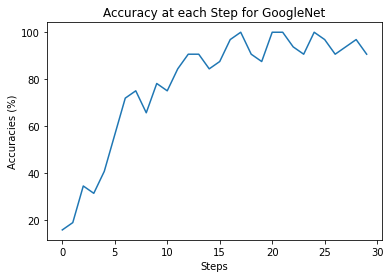

In [10]:
import matplotlib.pyplot as pyplot
import numpy as np

y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for GoogleNet")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(y_axis)

pyplot.show()

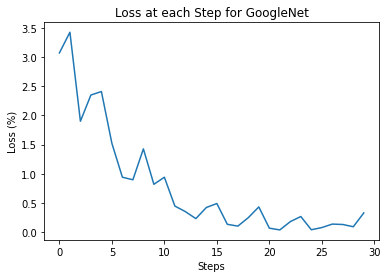

In [11]:
y_axis = np.array(loss_list)

pyplot.title("Loss at each Step for GoogleNet")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss (%)")
pyplot.plot(y_axis)

pyplot.show()

In [12]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
       
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)

        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        print(pred)
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))


evaluate(test_dataLoader)

<ipython-input-12-cdcabdabfae6>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([60, 32, 38,  7,  1, 61,  1, 61, 25, 53, 47, 18, 39, 16, 31, 20,  1, 19,
        61, 54, 32, 46, 19, 61, 56, 18,  3, 53, 44, 47, 19, 38],
       device='cuda:0')
tensor([39, 10, 53, 39, 13, 45, 56, 39, 61, 41, 18, 53, 28, 36,  1, 26,  7, 56,
        38, 40, 47, 56, 47, 32, 56,  3, 32, 28, 47, 39, 22, 53],
       device='cuda:0')
tensor([53, 32, 61, 22, 39, 13, 24, 54, 32, 40, 18,  7, 61,  6, 46, 61,  3, 41,
        45, 22,  7, 13, 61, 61, 22, 47, 22, 19, 13, 48, 41,  1],
       device='cuda:0')
tensor([29, 53, 53, 32, 40, 56, 35,  7, 47, 47, 48,  2,  7, 50, 17, 38, 61, 14,
        22, 47, 44, 37, 28, 39, 38,  1, 53, 14, 37, 56, 38, 39],
       device='cuda:0')
tensor([32, 61, 53,  3, 53, 40, 32, 34, 10, 32, 17, 22, 59, 21, 47, 43, 17, 43,
        32, 28, 43, 51, 61, 13, 41, 45, 47, 21, 12, 38, 38, 19],
       device='cuda:0')
tensor([38, 38, 53, 61, 19, 37, 22, 35,  8, 22, 61, 47,  8, 32, 53, 53, 47, 61,
         1, 27, 39, 40, 32,  7, 54, 56,  1, 26, 19, 32, 41, 59],
       dev

In [13]:
print('Accuracy List :', accuracy_list)
print('Loss List :', loss_list)

Accuracy List : [15.625, 18.75, 34.375, 31.25, 40.625, 56.25, 71.875, 75.0, 65.625, 78.125, 75.0, 84.375, 90.625, 90.625, 84.375, 87.5, 96.875, 100.0, 90.625, 87.5, 100.0, 100.0, 93.75, 90.625, 100.0, 96.875, 90.625, 93.75, 96.875, 90.625]
Loss List : [3.0697731971740723, 3.4239444732666016, 1.899926781654358, 2.348480701446533, 2.408179998397827, 1.5203582048416138, 0.9406969547271729, 0.8963980674743652, 1.425756812095642, 0.8191356062889099, 0.9404525756835938, 0.44649532437324524, 0.3511180877685547, 0.2315158247947693, 0.4217510521411896, 0.49003344774246216, 0.1334431916475296, 0.10286634415388107, 0.2481842041015625, 0.43154576420783997, 0.06761292368173599, 0.037610236555337906, 0.17957961559295654, 0.2670167088508606, 0.04044526070356369, 0.07766223698854446, 0.13743525743484497, 0.13075023889541626, 0.09183083474636078, 0.32847002148628235]


In [16]:
PATH = '/content/BTSD_GoogleNet.pt'
torch.save({
            'loss': train_loss,
            'accuracy': accuracy_list
            }, PATH)